# Setup

Perform all necessary imports up front

In [ ]:
!pip install --quiet armory-library armory-examples[cv]

In [ ]:
%matplotlib inline

from IPython.display import display

# armory-library imports
import armory.engine
import armory.evaluation
import armory.results

# armory-examples imports
import armory.examples.object_detection.license_plates_yolos as license_plates

In [ ]:
armory.logging.configure_logging()

# Define the evaluation

In [ ]:
evaluation = armory.evaluation.Evaluation(
    name="object-detection-license-plates-xai",
    description="Object detection of license-plates with explainability outputs",
    author="TwoSix",
)

with evaluation.autotrack():
    model, art_estimator = license_plates.load_model()
evaluation.use_model(model)

with evaluation.autotrack():
    dataset = license_plates.load_dataset(batch_size=4, shuffle=False)
evaluation.use_dataset(dataset)

with evaluation.autotrack():
    attack = license_plates.create_attack(art_estimator)

evaluation.use_metrics(
    license_plates.create_metrics()
)

evaluation.use_exporters(
    license_plates.create_exporters(model, export_every_n_batches=1, num_masks=1000)
)

with evaluation.add_chain("benign"):
    pass

with evaluation.add_chain("attack") as chain:
    chain.add_perturbation(attack)

engine = armory.engine.EvaluationEngine(
    evaluation,
    limit_test_batches=1,
    accelerator="cpu",
)

# Run the evaluation

In [ ]:
results = engine.run()
chains = [
    results.children["benign"],
    results.children["attack"],
]
titles = ["Benign", "Attack"]

# Metrics

In [ ]:
armory.results.plot_metrics(*chains)

Metric,benign,attack
epoch,0.000,0.000
linf_norm,0.000,1.000


In [ ]:
for chain in chains:
    print(chain.run_name)
    display(chain.artifacts["metrics/detection.txt"].json)

benign


{'true_positive_rate_mean': 0.75,
 'misclassification_rate_mean': 0.0,
 'disappearance_rate_mean': 0.25,
 'hallucinations_mean': 0.0}

attack


{'true_positive_rate_mean': 0.75,
 'misclassification_rate_mean': 0.0,
 'disappearance_rate_mean': 0.25,
 'hallucinations_mean': 0.0}

In [ ]:
for chain in chains:
    print(chain.run_name)
    display(chain.artifacts["metrics/map.txt"].json)

benign


{'map': 0.3947194814682007,
 'map_50': 0.7524752616882324,
 'map_75': 0.4224422574043274,
 'map_small': -1.0,
 'map_medium': 0.3947194814682007,
 'map_large': -1.0,
 'mar_1': 0.42500001192092896,
 'mar_10': 0.42500001192092896,
 'mar_100': 0.42500001192092896,
 'mar_small': -1.0,
 'mar_medium': 0.42500001192092896,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': 1.0}

attack


{'map': 0.40330031514167786,
 'map_50': 0.7524752616882324,
 'map_75': 0.4224422574043274,
 'map_small': -1.0,
 'map_medium': 0.40330031514167786,
 'map_large': -1.0,
 'mar_1': 0.44999998807907104,
 'mar_10': 0.44999998807907104,
 'mar_100': 0.44999998807907104,
 'mar_small': -1.0,
 'mar_medium': 0.44999998807907104,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': 1.0}

In [ ]:
for chain in chains:
    print(chain.run_name)
    display(chain.artifacts["metrics/tide.txt"].json)

benign


{'mAP': {'0.5': 0.7524752475247525,
  '0.55': 0.7524752475247525,
  '0.6': 0.7524752475247525,
  '0.65': 0.42244224422442206,
  '0.7': 0.42244224422442206,
  '0.75': 0.42244224422442206,
  '0.8': 0.42244224422442206,
  '0.85': 0.0,
  '0.9': 0.0,
  '0.95': 0.0},
 'errors': {'main': {'dAP': {'Cls': 0.0,
    'Loc': 0.0,
    'Both': 0.0,
    'Dupe': 0.0,
    'Bkg': 0.0,
    'Miss': 0.24752475247524758},
   'count': {'Cls': 0.0,
    'Loc': 0.0,
    'Both': 0.0,
    'Dupe': 0.0,
    'Bkg': 0.0,
    'Miss': 1.0}},
  'special': {'dAP': {'FalsePos': 0.0, 'FalseNeg': 0.24752475247524758},
   'count': {'FalseNeg': 1.0}}}}

attack


{'mAP': {'0.5': 0.7524752475247525,
  '0.55': 0.7524752475247525,
  '0.6': 0.7524752475247525,
  '0.65': 0.42244224422442206,
  '0.7': 0.42244224422442206,
  '0.75': 0.42244224422442206,
  '0.8': 0.42244224422442206,
  '0.85': 0.08580858085808578,
  '0.9': 0.0,
  '0.95': 0.0},
 'errors': {'main': {'dAP': {'Cls': 0.0,
    'Loc': 0.0,
    'Both': 0.0,
    'Dupe': 0.0,
    'Bkg': 0.0,
    'Miss': 0.24752475247524758},
   'count': {'Cls': 0.0,
    'Loc': 0.0,
    'Both': 0.0,
    'Dupe': 0.0,
    'Bkg': 0.0,
    'Miss': 1.0}},
  'special': {'dAP': {'FalsePos': 0.0, 'FalseNeg': 0.24752475247524758},
   'count': {'FalseNeg': 1.0}}}}

# Batch samples

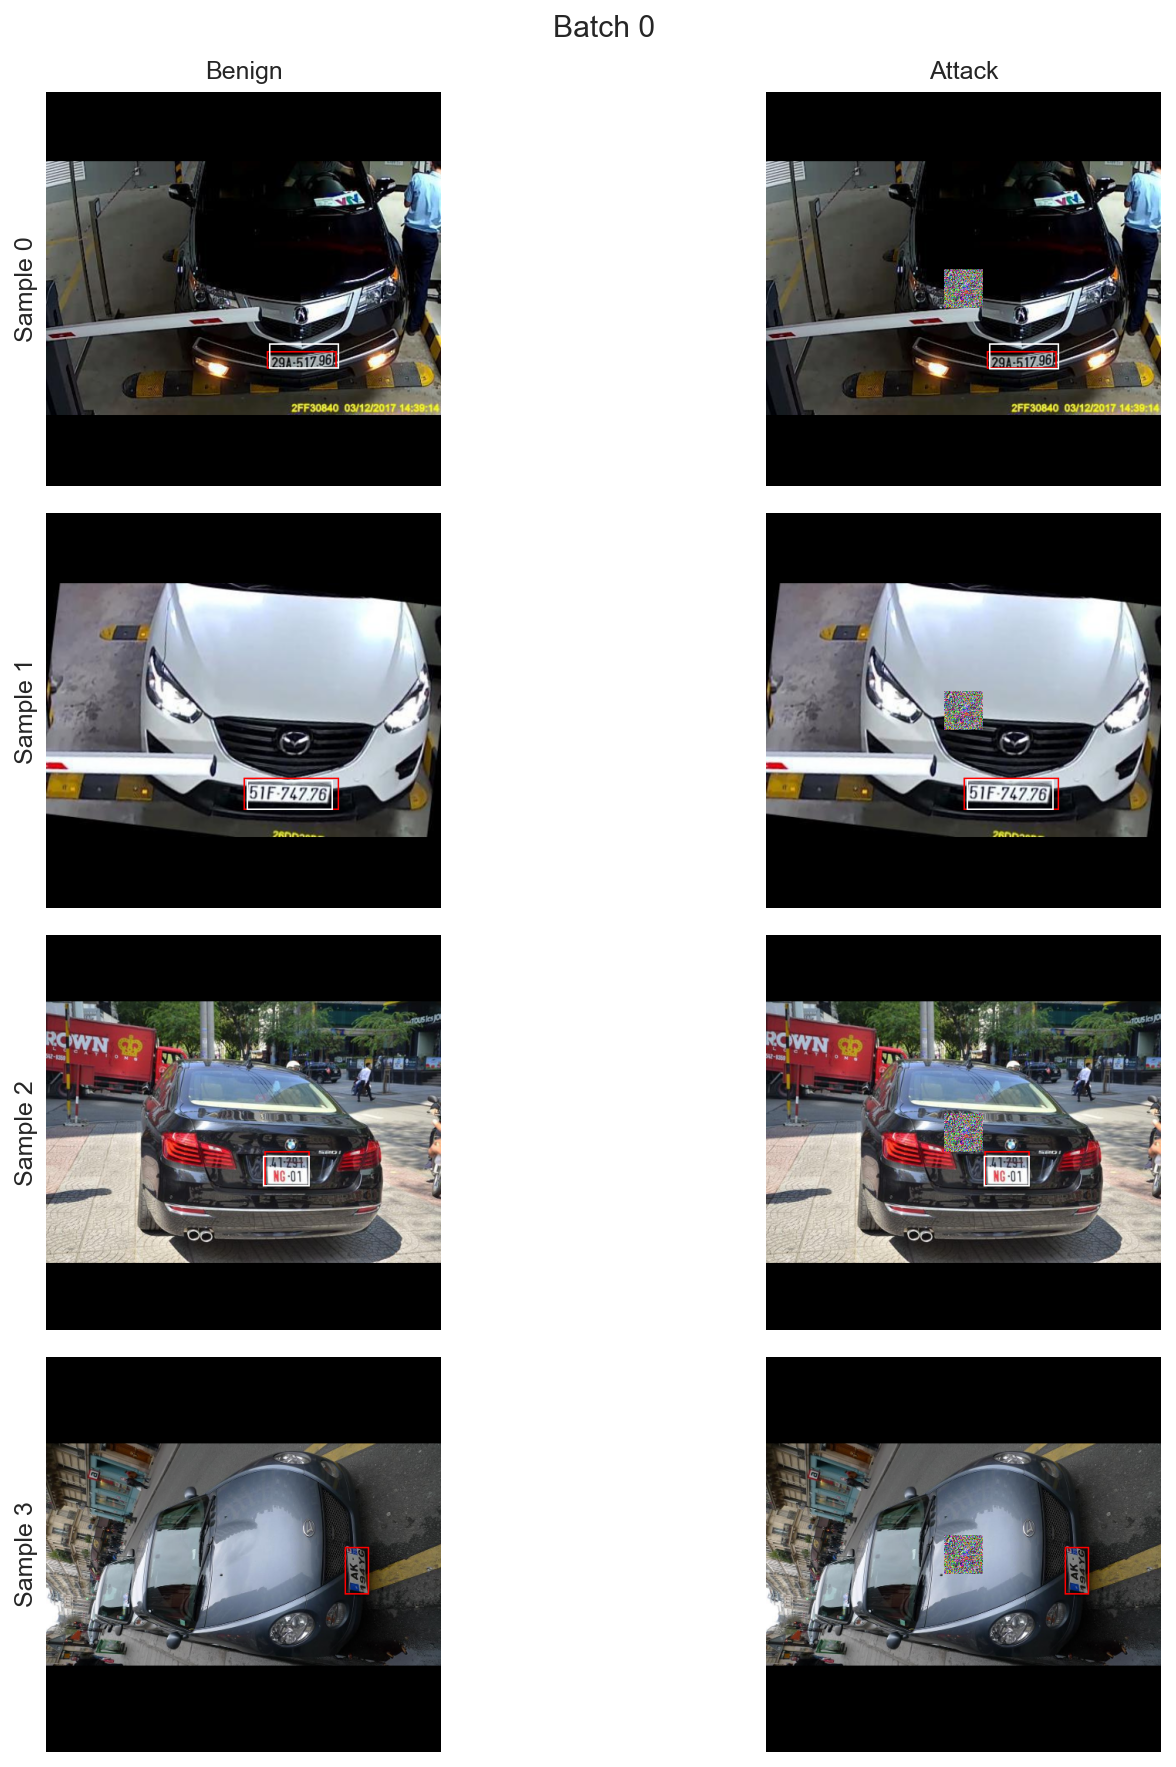

In [ ]:
armory.results.plot_in_grid(
    [
        [
            chain.batch(0).sample(i)["objects.png"].image
            for chain in chains
        ]
        for i in range(4)
    ],
    columns=titles,
    figsize=(12, 12),
    rows=[f"Sample {i}" for i in range(4)],
    title="Batch 0"
)

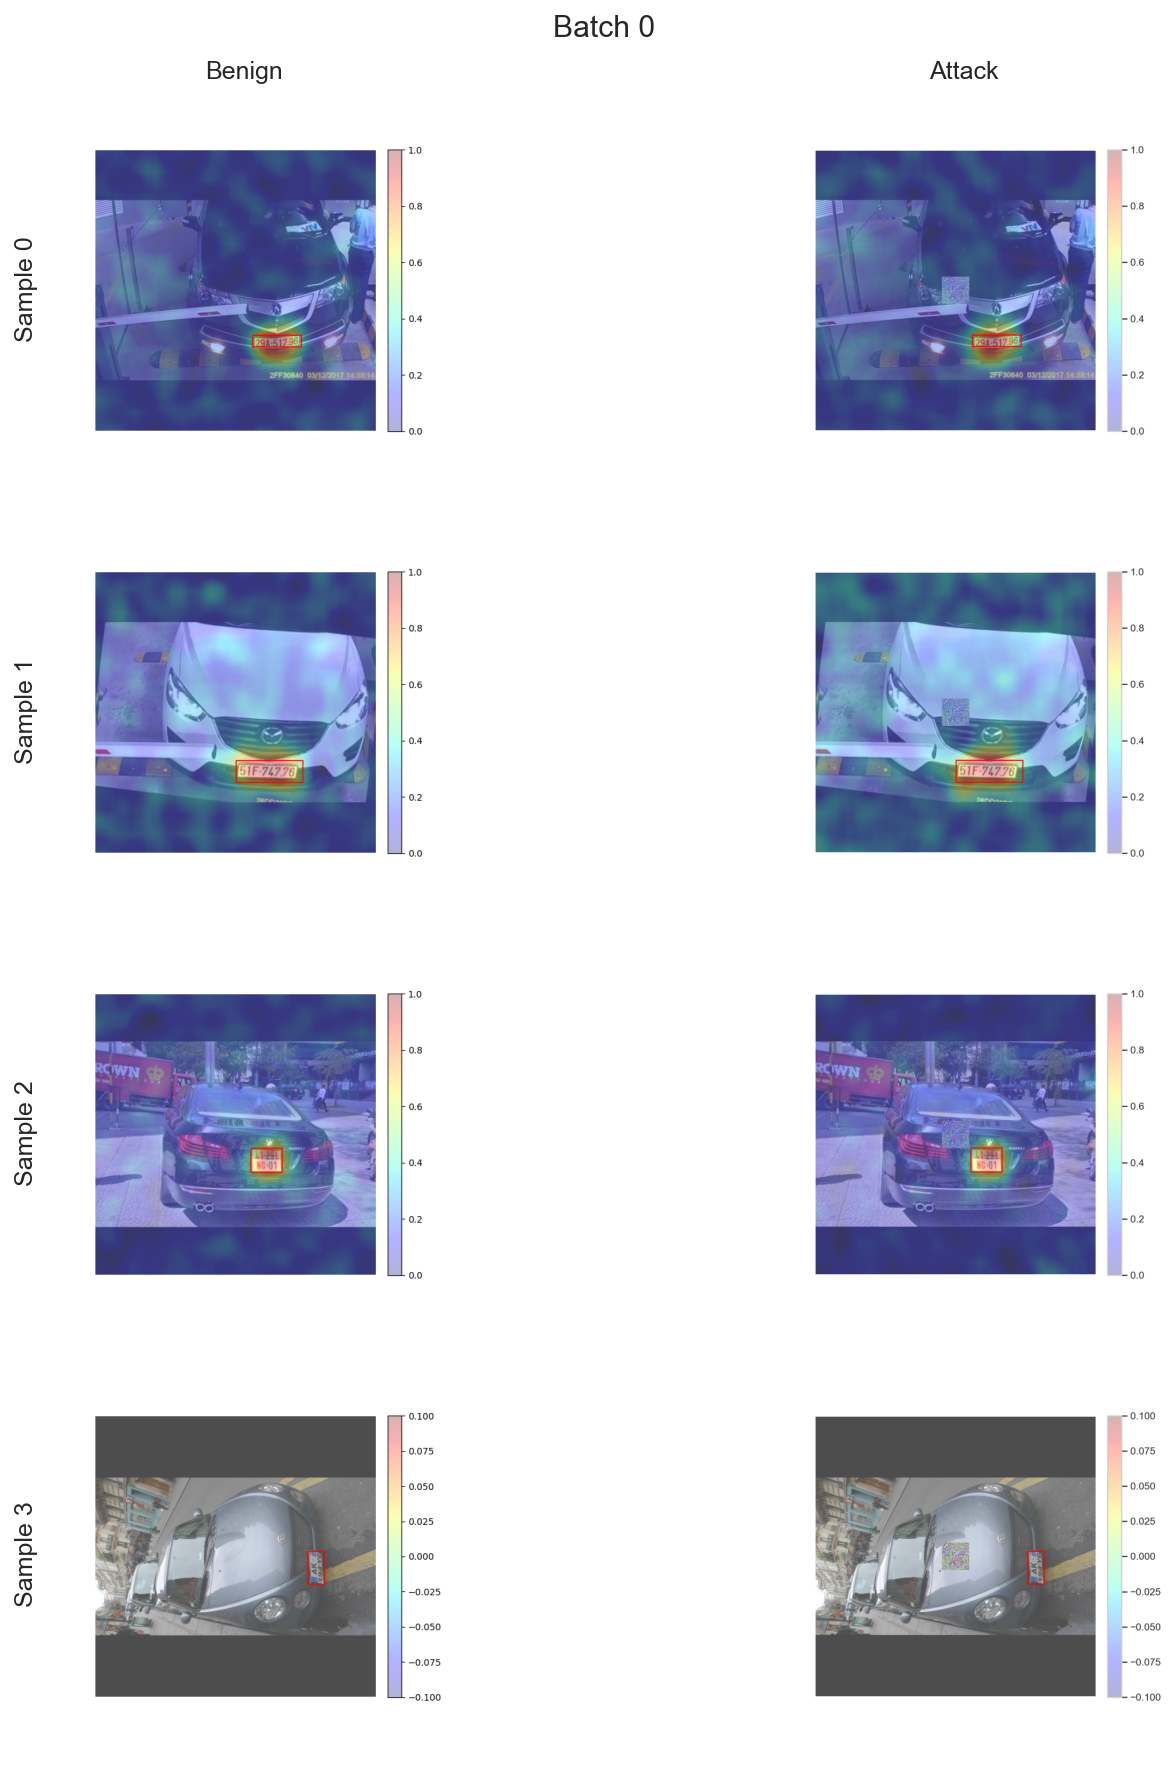

In [ ]:
armory.results.plot_in_grid(
    [
        [
            chain.batch(0).sample(i)["drise_00_target.png"].image
            for chain in chains
        ]
        for i in range(4)
    ],
    columns=titles,
    figsize=(12, 12),
    rows=[f"Sample {i}" for i in range(4)],
    title="Batch 0"
)